**Author:** Adel ADRAOUI (Université Paris Cité)

# Implementation of TDA-Based Critical Transition Detection

In this notebook, we implement the pipeline described in
*"Topological Recognition of Critical Transitions in Time Series of Cryptocurrencies"* using the following steps:

1. **Time–delay coordinate embedding** (Takens embedding)
2. **Sliding window** to produce point clouds from the time series
3. **Computation of 1-dimensional persistent homology** (Vietoris–Rips filtration)
4. **Computation of persistence landscapes** and their L1 norms
5. **k–means clustering** on a feature set (e.g., log–price, log–return, and the L1 norm)

We include two examples:
- A simulated Lorenz–type noisy chaotic time series (mimicking Section 3 in the paper)
- A cryptocurrency example using, for instance, BTC-USD from Yahoo Finance (mimicking Section 4)

In [1]:
# Import required libraries:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For time series embedding and TDA (giotto-tda):
from gtda.time_series import TakensEmbedding, SingleTakensEmbedding
from gtda.homology import VietorisRipsPersistence
from gtda.diagrams import PersistenceLandscape 
from gtda.pipeline import Pipeline

# For clustering and PCA:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

# For simulation of a chaotic map and noise:
import scipy

# Sklearn imports for time series CV and modeling
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score

try:
    import yfinance as yf
except ImportError:
    print("yfinance not installed. To install: pip install yfinance")

# Set random seed for reproducibility:
np.random.seed(2025)

## 1. Helper Functions

We define helper functions to:
- Create sliding windows (returning a list of segments)
- Compute the persistence landscape’s L1 norm from a persistence diagram (via giotto-tda)

In [2]:
def create_sliding_windows(data, window_size, stride=1):
    """
    Create sliding windows from a 2D array-like dataset.
    The input data should be of shape (n_samples, n_features), for example
    an embedded time series.

    Parameters
    ----------
    data : array-like, shape (n_samples, d)
        Input time series or embedded time series.
    window_size : int
        The length of each sliding window.
    stride : int, optional (default=1)
        The step size by which we move the window.

    Returns
    -------
    windows : ndarray, shape (n_windows, window_size, d)
        An array of overlapping windows.
    """
    n_samples = data.shape[0]
    windows = []
    for start in range(0, n_samples - window_size + 1, stride):
        windows.append(data[start: start + window_size])
    return np.array(windows)

def compute_persistence_landscape_norm(
    point_cloud, homology_dimensions=[1], n_jobs=1,
    sample_range=(0, 1), num_samples=200
):
    """
    Given a point cloud of shape (n_points, d), compute the L1 norm of the
    persistence landscape for the specified homology dimension(s).

    Parameters
    ----------
    point_cloud : ndarray, shape (n_points, d)
        A point cloud in R^d.
    homology_dimensions : list, optional (default=[1])
        Which homology dimensions to compute (e.g., [1] for H1 loops).
    n_jobs : int, optional (default=1)
        The number of parallel jobs.

    Returns
    -------
    L1_norm : float
        The approximate L1 norm of the persistence landscape.
    """
    # Create a pipeline for computing persistent homology and the landscape.
    persistence_pipeline = Pipeline(steps=[
        (
            "persistence",
            VietorisRipsPersistence(
                homology_dimensions=homology_dimensions,
                n_jobs=n_jobs,
                collapse_edges=True
            )
        ),
        ("landscape", PersistenceLandscape(n_layers=3))
    ])
    # giotto-tda expects shape (n_samples, n_points, d).
    X = point_cloud[np.newaxis, :, :]

    # Compute the persistence landscape.
    landscape = persistence_pipeline.fit_transform(X)

    # Approximate the integral over [0,1], with 'num_samples' subintervals.
    dx = (sample_range[1] - sample_range[0]) / num_samples
    L1_norm = 0.0
    # Sum up the areas under each layer.
    for layer in landscape[0]:
        L1_norm += np.trapz(np.abs(layer), dx=dx)

    return L1_norm

## 2. Example: Simulated Noisy Chaotic (Lorenz-type) Map

We consider a discrete-time dynamical system that, for certain parameter values, possesses a chaotic attractor (loosely inspired by the continuous Lorenz system, but discrete). **Note** that this differs from the classical continuous-time Lorenz equations.

The map is:
$$
f(x,y,z) = (y,\, z,\, M_1 + Bx + M_2y - z^2).
$$

For certain values of $M_1$, $B$, and $M_2$, all suitable initial conditions approach a chaotic attractor. We vary $M_2$ to observe the resulting bifurcation behavior.

Below, we generate a bifurcation diagram by scanning $M_2$, then we visualize a few attractors for selected parameter values. We also illustrate how to embed the resulting time series in Takens space and compute persistent homology/persistence landscapes.


In [3]:
# Define the map as a Python function.
def lorenz_type_map(state, M1, B, M2):
    """
    Compute one iteration of the discrete Lorenz-type map.

    Parameters
    ----------
    state : array-like, shape (3,)
        The current state [x, y, z].
    M1, B, M2 : float
        Real parameters for the map.

    Returns
    -------
    numpy.ndarray
        The next state, f(state) = (y, z, M1 + B*x + M2*y - z^2).
    """
    x, y, z = state
    return np.array([y, z, M1 + B * x + M2 * y - z**2])

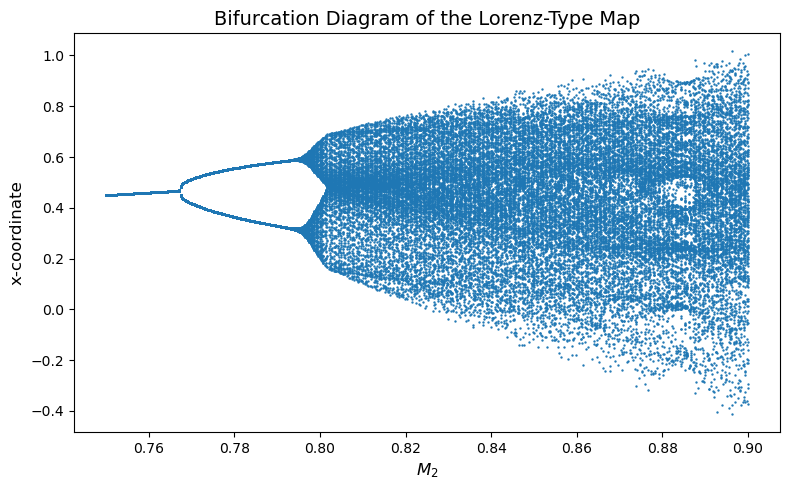

In [4]:
# Bifurcation diagram setup.
M1 = 0
B  = 0.7
M2_values = np.linspace(0.75, 0.9, 500)  # scanning from M2=0.75 to 0.9

M2_list = []
x_points = []

for M2 in M2_values:
    # Arbitrary initial condition.
    state = np.array([0.1, 0.1, 0.1])
    transient = 1000
    # Let the system settle.
    for _ in range(transient):
        state = lorenz_type_map(state, M1, B, M2)

    # Collect points for the attractor.
    sample_length = 100
    for _ in range(sample_length):
        state = lorenz_type_map(state, M1, B, M2)
        M2_list.append(M2)
        x_points.append(state[0])

# Plot the bifurcation diagram.
plt.figure(figsize=(8, 5))
plt.scatter(M2_list, x_points, s=0.5)
plt.xlabel(r'$M_2$', fontsize=12)
plt.ylabel('x-coordinate', fontsize=12)
plt.title('Bifurcation Diagram of the Lorenz-Type Map', fontsize=14)
plt.tight_layout()
plt.show()

In [5]:
def generate_trajectory(M1, B, M2, num_iter=2500, transient=500):
    """
    Generate the trajectory of the discrete Lorenz-type map.

    Parameters
    ----------
    M1, B, M2 : float
        Real parameters of the Lorenz-type map.
    num_iter : int
        Total number of iterations to generate.
    transient : int
        Number of initial transient iterations to discard.

    Returns
    -------
    trajectory : ndarray, shape (num_iter - transient, 3)
        The time series of [x, y, z] states.
    """
    state = np.array([0.1, 0.1, 0.1])  # initial condition
    trajectory = []

    for i in range(num_iter):
        state = lorenz_type_map(state, M1, B, M2)
        if i >= transient:
            trajectory.append(state.copy())

    return np.array(trajectory)

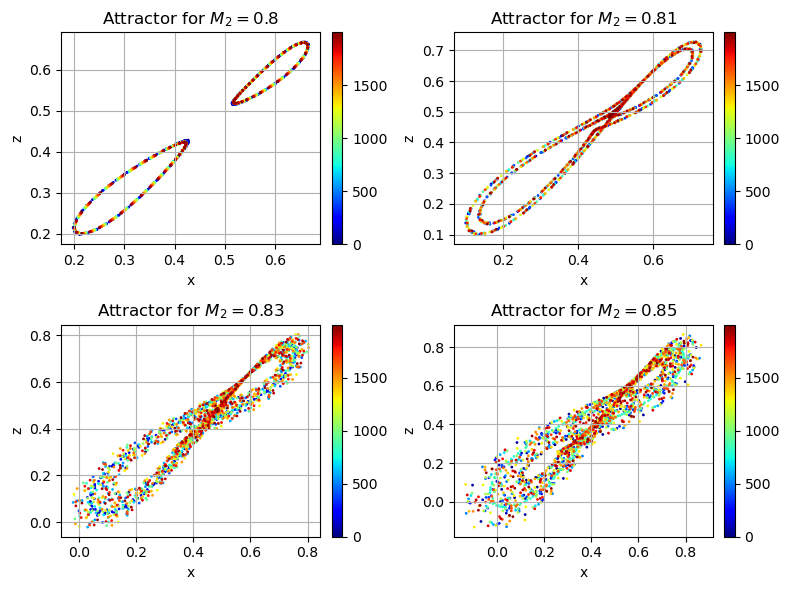

In [6]:
# Plot a few attractors for selected M2 values.
M1 = 0
B  = 0.7
M2_attractors = [0.8, 0.81, 0.83, 0.85]

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(8, 6))
axs = axs.flatten()

for idx, M2 in enumerate(M2_attractors):
    traj = generate_trajectory(M1, B, M2, num_iter=2500, transient=500)
    iteration_indices = np.arange(traj.shape[0])

    # 2D projection onto (x, z), colored by iteration index.
    sc = axs[idx].scatter(traj[:, 0], traj[:, 2], c=iteration_indices, cmap='jet', s=1)
    axs[idx].set_title(rf'Attractor for $M_2 = {M2}$', fontsize=12)
    axs[idx].set_xlabel('x')
    axs[idx].set_ylabel('z')
    axs[idx].grid(True)
    fig.colorbar(sc, ax=axs[idx], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

We now simulate a discrete-time Lorenz–type map with **slowly varying** $M_2$ and **small Gaussian noise**. We extract only the $x$-component of the resulting trajectories, then:

- Perform a time–delay embedding (dimension $d=4$)
- Use a sliding window ($w=100$) to produce point clouds
- Compute the L1 norm of the 1D persistence landscapes for each window.

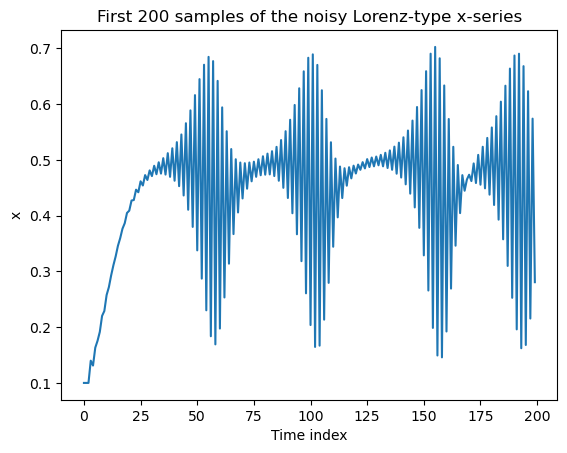

In [7]:
def simulate_lorenz_type(
    N, M1=0.0, B=0.7, M2_init=0.80, delta_M2=2.8e-5,
    noise_level=1e-3, x0=0.1, y0=0.1, z0=0.1
):
    """
    Simulate a Lorenz-type map with slowly varying M2 and additive Gaussian noise.

    Parameters
    ----------
    N : int
        Total length of the time series.
    M1, B : float
        Real parameters for the map.
    M2_init : float
        Initial value of M2.
    delta_M2 : float
        Increment added to M2 at each time step (slow drift).
    noise_level : float
        Std dev of the additive Gaussian noise on z.
    x0, y0, z0 : float
        Initial conditions.

    Returns
    -------
    x, y, z : ndarray of shape (N,)
        Time series of the x, y, z coordinates.
    M2 : ndarray of shape (N,)
        The M2 parameter value at each time step.
    """
    x = np.zeros(N)
    y = np.zeros(N)
    z = np.zeros(N)
    M2 = np.zeros(N)

    x[0], y[0], z[0] = x0, y0, z0
    M2[0] = M2_init

    for t in range(N - 1):
        x[t+1] = y[t]
        y[t+1] = z[t]
        z[t+1] = (M1 + B*x[t] + M2[t]*y[t]
                  - z[t]**2 + noise_level * np.random.randn())
        M2[t+1] = M2[t] + delta_M2

    return x, y, z, M2

# Simulation:
N_sim = 2100
x_sim, y_sim, z_sim, M2_sim = simulate_lorenz_type(N_sim)
x_series = x_sim  # We focus on x

plt.plot(x_series[:200])
plt.title('First 200 samples of the noisy Lorenz-type x-series')
plt.xlabel('Time index')
plt.ylabel('x')
plt.show()

### 2.1. Time–Delay Embedding and Sliding Window

We embed the $x$-series in $\mathbb{R}^4$ (with time delay = 1) and extract windows of length 100.

In [8]:
embedding_dimension = 4
time_delay = 1

single_takens = SingleTakensEmbedding(dimension=embedding_dimension, time_delay=time_delay)
embedded = single_takens.fit_transform(x_series.reshape(-1, 1))
print("Embedded shape:", embedded.shape)

window_size = 100
embedded_windows = create_sliding_windows(embedded, window_size=window_size, stride=1)
print("Number of sliding windows:", embedded_windows.shape[0])
print("Each window shape:", embedded_windows.shape[1:])

Embedded shape: (2098, 3)
Number of sliding windows: 1999
Each window shape: (100, 3)


### 2.2. Compute the L1 Norm of Persistence Landscapes
We now compute the L1 norm for each sliding window.

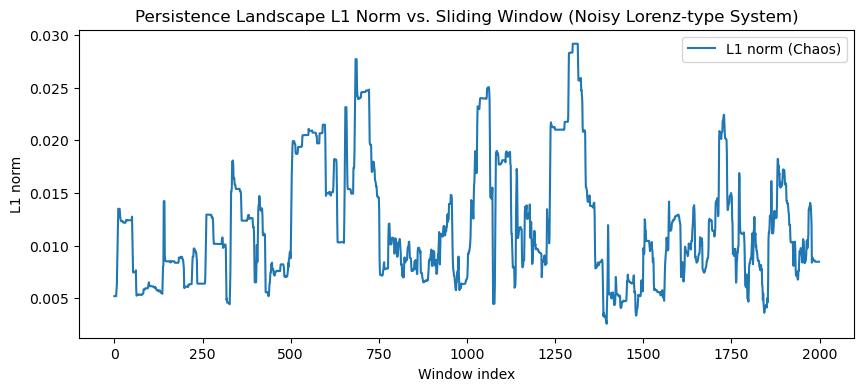

In [9]:
chaos_landscape_norms = []
for i in range(embedded_windows.shape[0]):
    norm_val = compute_persistence_landscape_norm(
        embedded_windows[i], homology_dimensions=[1], n_jobs=1
    )
    chaos_landscape_norms.append(norm_val)

chaos_landscape_norms = np.array(chaos_landscape_norms)

plt.figure(figsize=(10,4))
plt.plot(chaos_landscape_norms, label="L1 norm (Chaos)")
plt.xlabel("Window index")
plt.ylabel("L1 norm")
plt.title("Persistence Landscape L1 Norm vs. Sliding Window (Noisy Lorenz-type System)")
plt.legend()
plt.show()

### Brief Demonstration of a Single Window’s Persistence Diagram & Landscape

In [10]:
window_size = 100      # sliding window of 100 points
start_idx = 500        # arbitrary start index in the embedded series
window = embedded[start_idx:start_idx + window_size, :]
# giotto-tda expects the point cloud input as a 3D array: (n_samples, n_points, ambient_dimension)
X_window = window[np.newaxis, :, :]

In [11]:
VR = VietorisRipsPersistence(homology_dimensions=[0, 1], collapse_edges=True, n_jobs=1)
diagrams = VR.fit_transform(X_window)

Extract the single persistence diagram from this batch

In [12]:
diagram = diagrams[0]
# If the diagram has 4 columns, we only need the first 3 (dimension, birth, death)
if diagram.shape[1] > 3:
    diagram = diagram[:, :3]

# Separate H0 and H1 properly:
h0 = diagram[diagram[:, 2] == 0]
h1 = diagram[diagram[:, 2] == 1]

# Compute the persistence landscape using giotto-tda.
PL = PersistenceLandscape(n_layers=3)  # 3 layers, 200 sample points
landscape = PL.fit_transform(diagrams)
# Reshape (since we have 1 sample) into (n_layers, 200)
landscape_reshaped = landscape[0].reshape(3, 200)
x_landscape = np.linspace(0, 1, 200)

Plotting all results

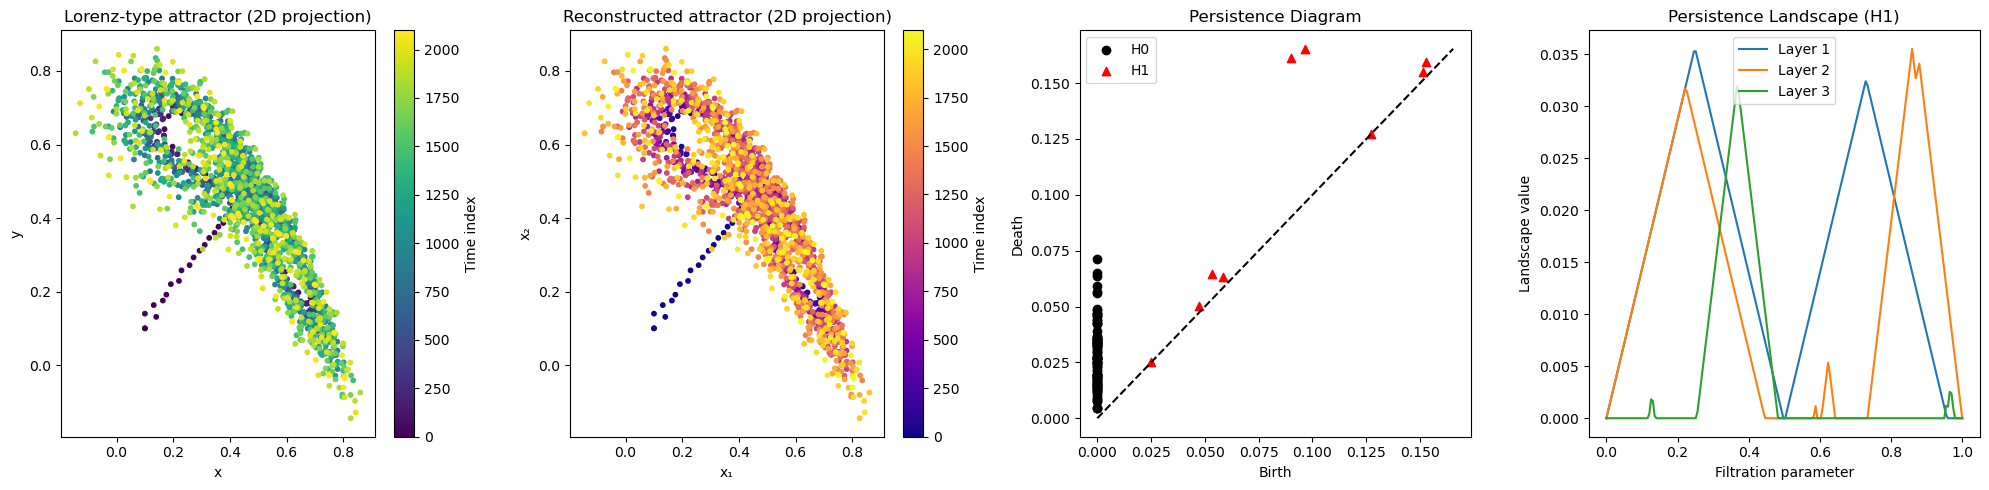

In [13]:
fig = plt.figure(figsize=(20, 5))

# (a) Plot the original attractor as a 2D scatter plot (x-y projection) with color representing time.
ax1 = fig.add_subplot(1, 4, 1)
time_indices = np.arange(len(x_sim))
sc1 = ax1.scatter(x_sim, y_sim, c=time_indices, cmap='viridis', s=10)
ax1.set_title("Lorenz-type attractor (2D projection)")
ax1.set_xlabel("x")
ax1.set_ylabel("y")
plt.colorbar(sc1, ax=ax1, label="Time index")

# (b) Plot the reconstructed attractor (x1 vs. x2) with colors for time.
ax2 = fig.add_subplot(1, 4, 2)
time_indices_emb = np.arange(embedded.shape[0])
sc2 = ax2.scatter(embedded[:, 0], embedded[:, 1], c=time_indices_emb, cmap='plasma', s=10)
ax2.set_title("Reconstructed attractor (2D projection)")
ax2.set_xlabel("x₁")
ax2.set_ylabel("x₂")
plt.colorbar(sc2, ax=ax2, label="Time index")

# (c) Plot the persistence diagram.
ax3 = fig.add_subplot(1, 4, 3)
ax3.scatter(h0[:, 0], h0[:, 1], marker='o', c='black', label='H0')
ax3.scatter(h1[:, 0], h1[:, 1], marker='^', c='red', label='H1')

# Make a diagonal line for reference
mins = diagram[:, :2].min()
maxs = diagram[:, :2].max()
ax3.plot([mins, maxs], [mins, maxs], 'k--')

ax3.set_title("Persistence Diagram")
ax3.set_xlabel("Birth")
ax3.set_ylabel("Death")
ax3.legend()

# (d) Plot the persistence landscape (H1) for the three layers.
ax4 = fig.add_subplot(1, 4, 4)
for k in range(3):
    ax4.plot(x_landscape, landscape_reshaped[k], label=f'Layer {k+1}')
ax4.set_title("Persistence Landscape (H1)")
ax4.set_xlabel("Filtration parameter")
ax4.set_ylabel("Landscape value")
ax4.legend()

plt.tight_layout()
plt.show()


## 3. Cryptocurrency Example: Data Acquisition and TDA Pipeline

Next, we turn to real financial data—in this example, **Bitcoin daily prices** from Yahoo Finance. We:

1. Compute log–price and log–returns.
2. Perform time–delay embedding (dimension $d=4$) of the log–return series.
3. Use a sliding window ($w=50$) to produce point clouds.
4. Compute the L1 norm of the persistence landscape ($H_1$) for each window.
5. Create a feature set combining log–price, log–return, and the L1 norm, and run k–means clustering to identify different regimes.

**Note:** For large-scale data or intraday data, we will want to optimize window sizes, time delays, parallelization...


In [14]:
def get_crypto_data(ticker, start="2022-01-01", end="2025-01-01"):
    """
    Get historical daily close prices via yfinance.

    Parameters
    ----------
    ticker : str
        Ticker symbol, e.g. 'BTC-USD'.
    start, end : str
        Date range in 'YYYY-MM-DD' format.

    Returns
    -------
    data : DataFrame
        With columns ['Close'] and corresponding date index.
    """
    data = yf.download(ticker, start=start, end=end)
    data = data[['Close']]
    data.dropna(inplace=True)
    return data

# Example: Bitcoin data
btc_data = get_crypto_data("BTC-USD", start="2022-01-01", end="2025-01-01")
btc_data.head()

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close
Ticker,BTC-USD
Date,
2022-01-01,47686.812500
2022-01-02,47345.218750
2022-01-03,46458.117188
2022-01-04,45897.574219
2022-01-05,43569.003906


### 3.1. Compute Log Prices and Log Returns

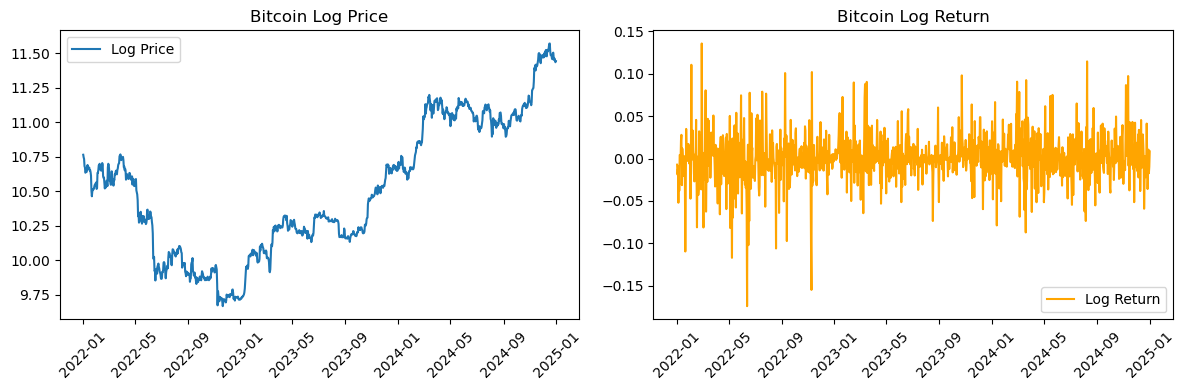

In [15]:
btc_data['log_price'] = np.log(btc_data['Close'])
btc_data['log_return'] = btc_data['log_price'].diff()

# Remove NaN from the first diff.
btc_data.dropna(inplace=True)

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(btc_data.index, btc_data['log_price'], label="Log Price")
plt.title("Bitcoin Log Price")
plt.legend()
plt.xticks(rotation=45)  # Rotate xtick labels by 45 degrees

plt.subplot(1, 2, 2)
plt.plot(btc_data.index, btc_data['log_return'], label="Log Return", color='orange')
plt.title("Bitcoin Log Return")
plt.legend()
plt.xticks(rotation=45)  # Rotate xtick labels by 45 degrees

plt.tight_layout()
plt.show()

### 3.2. Time–Delay Embedding of the Log–Return Series

We embed the log_return series in $\mathbb{R}^4$ with a time delay of 1, then create windows of length 50.

In [16]:
log_return_series = btc_data['log_return'].values

single_takens_crypto = SingleTakensEmbedding(dimension=4, time_delay=1)
embedded_crypto = single_takens_crypto.fit_transform(log_return_series.reshape(-1,1))
print("Embedded crypto shape:", embedded_crypto.shape)

window_size_crypto = 50
crypto_windows = create_sliding_windows(embedded_crypto, window_size=window_size_crypto, stride=1)
print("Number of crypto windows:", crypto_windows.shape[0])
print("Shape of each window:", crypto_windows.shape[1:])

Embedded crypto shape: (1092, 4)
Number of crypto windows: 1043
Shape of each window: (50, 4)


### 3.3. Compute the L1 Norm of Persistence Landscapes for Crypto Windows

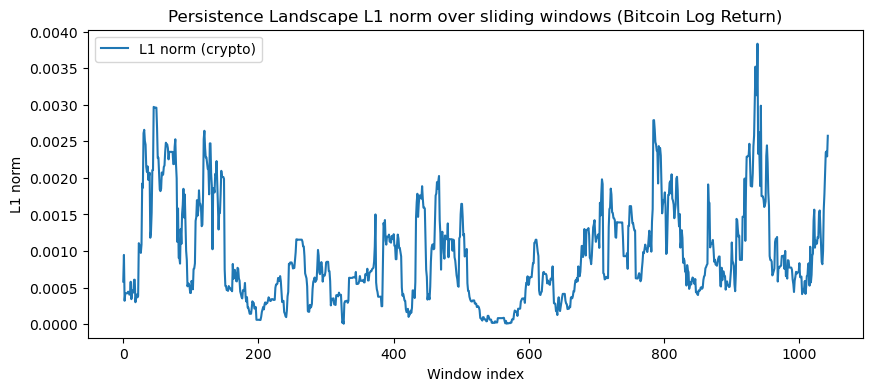

In [17]:
crypto_landscape_norms = []
for i in range(crypto_windows.shape[0]):
    norm_val = compute_persistence_landscape_norm(crypto_windows[i], homology_dimensions=[1], n_jobs=1)
    crypto_landscape_norms.append(norm_val)

crypto_landscape_norms = np.array(crypto_landscape_norms)

plt.figure(figsize=(10,4))
plt.plot(crypto_landscape_norms, label="L1 norm (crypto)")
plt.xlabel("Window index")
plt.ylabel("L1 norm")
plt.title("Persistence Landscape L1 norm over sliding windows (Bitcoin Log Return)")
plt.legend()
plt.show()

**c/c**: Successfully extracted persistence landscape (L1 norm) features from Bitcoin data using Takens embedding and sliding windows

### 3.4. Prepare Features & Cluster with k–Means

We build a feature matrix of size $(n, 3)$:
1. Normalized log_price (aligned with each window’s end)
2. Normalized log_return (end of window)
3. The L1 norm from the window.

Then we apply k–means clustering and visualize via PCA.


In [18]:
# Match the last crypto_windows.shape[0] points:
feature_dates = btc_data.index[-crypto_windows.shape[0]:]
log_prices_feature = btc_data['log_price'].values[-crypto_windows.shape[0]:]
log_returns_feature = btc_data['log_return'].values[-crypto_windows.shape[0]:]

features = np.vstack([log_prices_feature, log_returns_feature, crypto_landscape_norms]).T

scaler = MinMaxScaler()
features_norm = scaler.fit_transform(features)

k = 8
kmeans = KMeans(n_clusters=k, n_init=50, random_state=42)
clusters = kmeans.fit_predict(features_norm)

df_features = pd.DataFrame(features, columns=["log_price", "log_return", "L1_norm"])
df_features['cluster'] = clusters
df_features['date'] = feature_dates

df_features.head()

,log_price,log_return,L1_norm,cluster,date
0,10.526657,-0.026184,0.000583,1,2022-02-23
1,10.554056,0.027400,0.000947,1,2022-02-24
2,10.576795,0.022738,0.000320,1,2022-02-25
3,10.574009,-0.002785,0.000423,1,2022-02-26
4,10.537675,-0.036335,0.000423,1,2022-02-27


### 3.5. Visualize Clustering via PCA

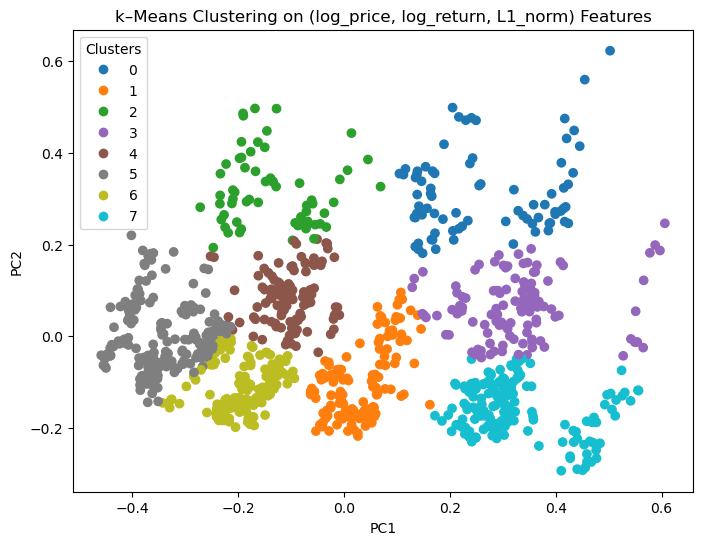

In [19]:
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_norm)

plt.figure(figsize=(8,6))
scatter = plt.scatter(features_pca[:,0], features_pca[:,1], c=clusters, cmap='tab10')
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.title("k–Means Clustering on (log_price, log_return, L1_norm) Features")
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.show()

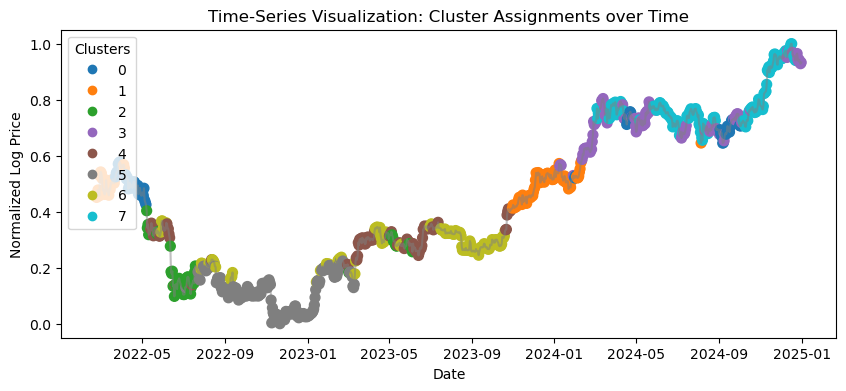

In [20]:
plt.figure(figsize=(10, 4))
# Plot normalized log_price as a line for context (or choose another feature)
plt.plot(feature_dates, features_norm[:, 0], color='gray', alpha=0.5, label="Normalized Log Price")

# Overlay the cluster assignments using a scatter plot
scatter = plt.scatter(feature_dates, features_norm[:, 0], c=clusters, cmap='tab10', s=50, label="Cluster")
plt.xlabel("Date")
plt.ylabel("Normalized Log Price")
plt.title("Time-Series Visualization: Cluster Assignments over Time")
plt.legend(*scatter.legend_elements(), title="Clusters", loc="upper left")
plt.show()

**c/c**: K–means clustering on TDA features, log–price, and log–return identified potential market regimes

## 4. Predictive Modeling Using TDA-Based Features

In addition to clustering regimes or identifying critical transitions visually, we can use TDA-based features—like the persistence landscape L1 norm—in predictive models.

**Regression Example** (Walk-Forward Validation): Predict a *5-day future log-return*, comparing a Linear Regression model with a Random Forest.

Below is a more detailed regression workflow:
1. We create a 5-day future log-return target: 
$$
\text{future}_{5d}\_\text{return} = \log(P_{t+5}) - \log(P_t).
$$
2. We lag the TDA-based feature (L1_norm) by +1 day to avoid look-ahead bias.
3. We compare a Linear Regression model with a Random Forest, tuning via RandomizedSearchCV.
4. We use TimeSeriesSplit for walk-forward evaluation.
5. We measure out-of-sample performance (MSE, RMSE, $R^2$) aggregated across folds, and visualize predictions vs. actual values.


**Data Prep**

In [21]:
# Sort ascending by date
df_features = df_features.sort_values('date').reset_index(drop=True)

# Lag the TDA feature (L1_norm) by +1 day so it reflects only past info at time t
df_features['L1_norm_lagged'] = df_features['L1_norm'].shift(1)

# Create a 5-day future log-return
df_features['future_5day_return'] = df_features['log_price'].shift(-5) - df_features['log_price']

# Drop rows with NaN from shifts/lags
df_features.dropna(subset=['L1_norm_lagged', 'future_5day_return'], inplace=True)

# Define feature matrix (X) and target (y)
feature_cols = ['log_price', 'log_return', 'L1_norm_lagged']
X = df_features[feature_cols].values
y = df_features['future_5day_return'].values

# Keep track of dates (useful for plotting results in time order)
dates = df_features['date'].values

# (Optional) scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

**Setup time series split**

In [22]:
tscv = TimeSeriesSplit(n_splits=5)

**RF Hyperparameters search**

In [23]:
param_distributions = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 7, 10],
    'min_samples_leaf': [1, 2, 5]
}

rf_base = RandomForestRegressor(random_state=42)
rf_search = RandomizedSearchCV(
    estimator=rf_base,
    param_distributions=param_distributions,
    n_iter=5,
    scoring='neg_mean_squared_error',
    cv=tscv,
    random_state=42,
    n_jobs=-1
)

rf_search.fit(X_scaled, y)
print("RandomForest - Best Params:", rf_search.best_params_)
best_rf_model = rf_search.best_estimator_

# We'll compare against a simple Linear Regression
lr_model = LinearRegression()

RandomForest - Best Params: {'n_estimators': 100, 'min_samples_leaf': 5, 'max_depth': 5}


**Walk-Forward evaluation for LR vs. RF**

In [24]:
all_test_dates = []
all_test_actuals = []
all_test_preds_lr = []
all_test_preds_rf = []

for fold_idx, (train_idx, test_idx) in enumerate(tscv.split(X_scaled)):
    X_train, X_test = X_scaled[train_idx], X_scaled[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]
    date_test = dates[test_idx]

    # Train Linear Regression
    lr_model.fit(X_train, y_train)
    y_pred_lr = lr_model.predict(X_test)

    # Train Random Forest with best hyperparams
    best_rf_model.fit(X_train, y_train)
    y_pred_rf = best_rf_model.predict(X_test)

    # Collect results
    all_test_dates.extend(date_test)
    all_test_actuals.extend(y_test)
    all_test_preds_lr.extend(y_pred_lr)
    all_test_preds_rf.extend(y_pred_rf)

# Convert to arrays (optional)
all_test_dates = np.array(all_test_dates)
all_test_actuals = np.array(all_test_actuals)
all_test_preds_lr = np.array(all_test_preds_lr)
all_test_preds_rf = np.array(all_test_preds_rf)

**Compare error metrics**

In [25]:
def regression_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, r2

In [26]:
mse_lr, rmse_lr, r2_lr = regression_metrics(all_test_actuals, all_test_preds_lr)
mse_rf, rmse_rf, r2_rf = regression_metrics(all_test_actuals, all_test_preds_rf)

print("\n--- Walk-Forward Aggregated Metrics ---")
print("Linear Regression:")
print(f"  MSE:  {mse_lr:.6f}")
print(f"  RMSE: {rmse_lr:.6f}")
print(f"  R^2:  {r2_lr:.4f}")

print("\nRandom Forest:")
print(f"  MSE:  {mse_rf:.6f}")
print(f"  RMSE: {rmse_rf:.6f}")
print(f"  R^2:  {r2_rf:.4f}")


--- Walk-Forward Aggregated Metrics ---
Linear Regression:
  MSE:  0.003683
  RMSE: 0.060689
  R^2:  -0.0907

Random Forest:
  MSE:  0.005229
  RMSE: 0.072313
  R^2:  -0.5486


**Visualizations:** PREDICTED vs. ACTUAL

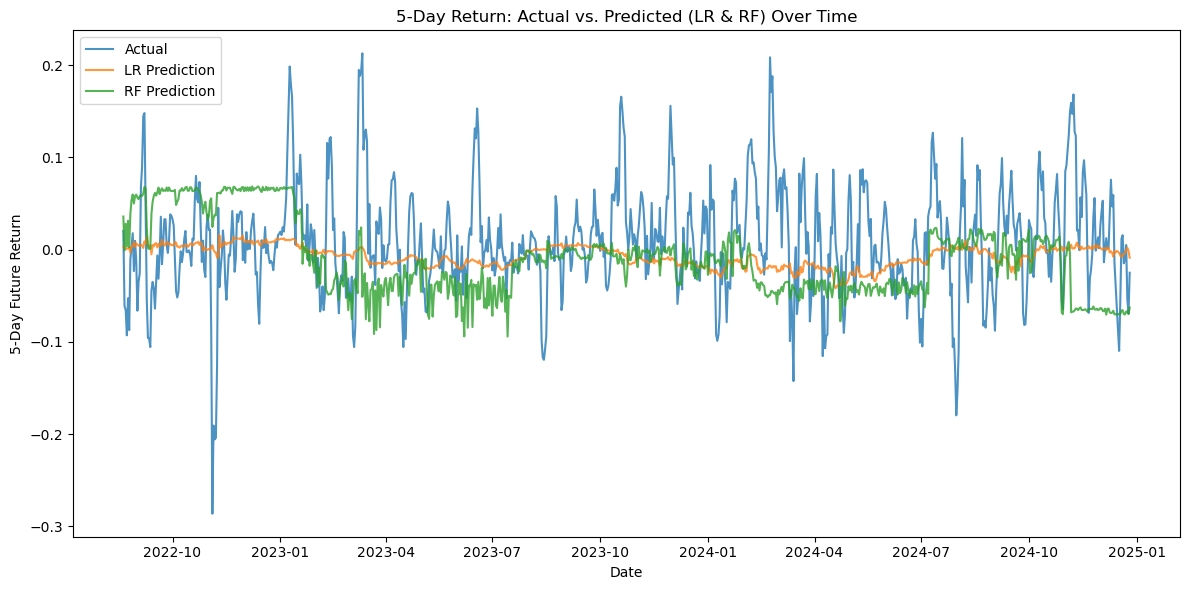

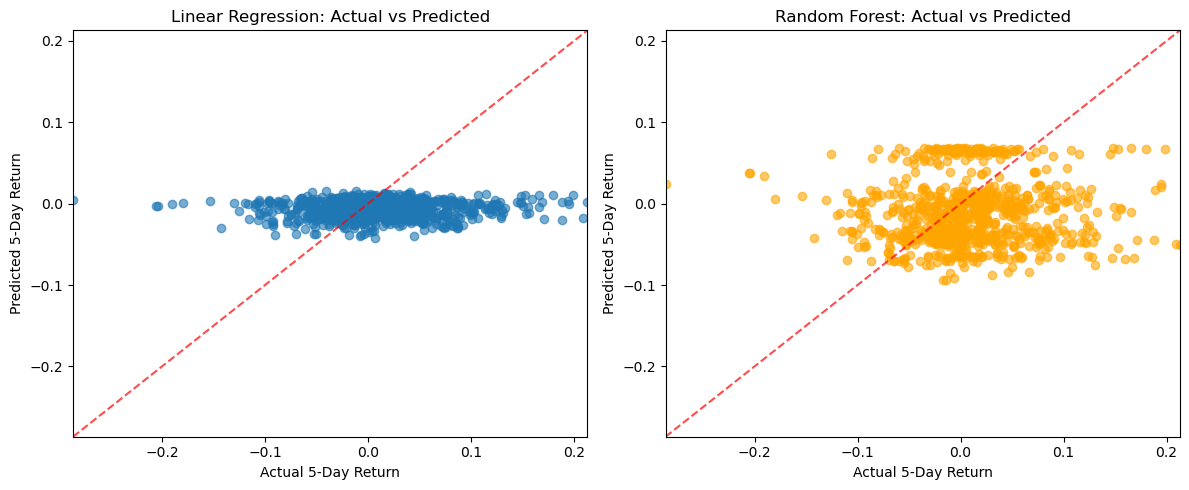

In [27]:
df_pred = pd.DataFrame({
    'date': all_test_dates,
    'actual_return': all_test_actuals,
    'pred_lr': all_test_preds_lr,
    'pred_rf': all_test_preds_rf
})
df_pred.sort_values('date', inplace=True)

# (A) Over Time
plt.figure(figsize=(12,6))
plt.plot(df_pred['date'], df_pred['actual_return'], label='Actual', alpha=0.8)
plt.plot(df_pred['date'], df_pred['pred_lr'], label='LR Prediction', alpha=0.8)
plt.plot(df_pred['date'], df_pred['pred_rf'], label='RF Prediction', alpha=0.8)
plt.title("5-Day Return: Actual vs. Predicted (LR & RF) Over Time")
plt.xlabel("Date")
plt.ylabel("5-Day Future Return")
plt.legend()
plt.tight_layout()
plt.show()

# (B) Scatter Plots
fig, axs = plt.subplots(1, 2, figsize=(12,5))

# Linear Regression scatter
axs[0].scatter(df_pred['actual_return'], df_pred['pred_lr'], alpha=0.6)
axs[0].set_title("Linear Regression: Actual vs Predicted")
axs[0].set_xlabel("Actual 5-Day Return")
axs[0].set_ylabel("Predicted 5-Day Return")
lims_lr = [
    df_pred[['actual_return','pred_lr']].min().min(),
    df_pred[['actual_return','pred_lr']].max().max()
]
axs[0].plot(lims_lr, lims_lr, 'r--', alpha=0.7)
axs[0].set_xlim(lims_lr)
axs[0].set_ylim(lims_lr)

# Random Forest scatter
axs[1].scatter(df_pred['actual_return'], df_pred['pred_rf'], alpha=0.6, color='orange')
axs[1].set_title("Random Forest: Actual vs Predicted")
axs[1].set_xlabel("Actual 5-Day Return")
axs[1].set_ylabel("Predicted 5-Day Return")
lims_rf = [
    df_pred[['actual_return','pred_rf']].min().min(),
    df_pred[['actual_return','pred_rf']].max().max()
]
axs[1].plot(lims_rf, lims_rf, 'r--', alpha=0.7)
axs[1].set_xlim(lims_rf)
axs[1].set_ylim(lims_rf)

plt.tight_layout()
plt.show()


**c/c**: Both Linear Regression and Random Forest models underperformed (negative $R^2$), with LR slightly outperforming RF

## 4. Summary

In this notebook, we:
1. **Simulated a Noisy Lorenz-type Map:**  
   - Performed time–delay embedding and applied sliding windows.
   - Computed persistence landscapes (L1 norm) to track changes in topology over time.

2. **Processed Cryptocurrency Data (BTC-USD):**  
   - Computed log–price and log–return.
   - Applied time–delay embedding and sliding window TDA, extracting the L1 norm for each window.

3. **Constructed a Feature Set & Identified Regimes:**  
   - Built a feature set from normalized log–price, log–return, and the lagged L1 norm.
   - Applied k–means clustering to uncover potential structural regimes in the market data.

4. **Demonstrated Predictive Modeling with TDA-Based Features:**  
   - Created a target for a 5-day future log–return.
   - Compared Linear Regression and Random Forest models using walk–forward validation.
   - Both models underperformed relative to a baseline (negative \( R^2 \)), with Linear Regression slightly outperforming Random Forest.

This pipeline demonstrates that persistent homology on embedded time-series windows can capture critical structural changes. However, while the topological features show promise for regime detection, further refinement—such as optimizing embedding parameters, exploring additional TDA summaries, and integrating alternative modeling techniques—is needed to improve predictive accuracy.